# validation_train
Este notebook é dedicado à parte de validação (cross-validation / hold-out validation), calculo do threshold ótimo e aplicação nos modelos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# load the final dataframe from data_prep 
df_data = pd.read_csv('diabetic_data_df.csv')

In [3]:
# Load columns to use from data_prep
col2use = pd.read_csv('col2use.csv')
col2use = col2use['col2use'].tolist()

In [4]:
df_data.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Asian,race_Caucasian,...,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK,age_group,has_weight,OUTPUT_LABEL
0,1,41,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,3,59,0,18,0,0,0,9,0,1,...,0,0,0,0,0,0,1,10,0,0
2,2,11,5,13,2,0,1,6,0,0,...,0,0,0,0,0,0,1,20,0,0
3,2,44,1,16,0,0,0,7,0,1,...,0,0,0,0,0,0,1,30,0,0
4,1,51,0,8,0,0,0,5,0,1,...,0,0,0,0,0,0,1,40,0,0


In [5]:
col2use

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'race_UNK',
 'gender_Male',
 'gender_Unknown/Invalid',
 'max_glu_serum_>300',
 'max_glu_serum_None',
 'max_glu_serum_Norm',
 'A1Cresult_>8',
 'A1Cresult_None',
 'A1Cresult_Norm',
 'metformin_No',
 'metformin_Steady',
 'metformin_Up',
 'repaglinide_No',
 'repaglinide_Steady',
 'repaglinide_Up',
 'nateglinide_No',
 'nateglinide_Steady',
 'nateglinide_Up',
 'chlorpropamide_No',
 'chlorpropamide_Steady',
 'chlorpropamide_Up',
 'glimepiride_No',
 'glimepiride_Steady',
 'glimepiride_Up',
 'acetohexamide_Steady',
 'glipizide_No',
 'glipizide_Steady',
 'glipizide_Up',
 'glyburide_No',
 'glyburide_Steady',
 'glyburide_Up',
 'tolbutamide_Steady',
 'pioglitazone_No',
 'pioglitazone_Steady',
 'pioglitazone_Up',
 'rosiglitazone_No',
 'rosiglitazone_Steady',
 'rosigli

In [6]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

## Funções 

Geral para analises

In [7]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [9]:
def get_recall_specificity(y_actual, y_pred, thresh):
    recall = recall_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    return [recall, (1-specificity)]

def get_thresh_opt(y_actual, y_pred):
    dist = []
    for th in np.linspace(0, 1, 100):
        a = get_recall_specificity(y_actual, y_pred, th)
        dist.append([np.sqrt(np.power(a - np.array([0,1]), 2).sum()), th, a[0],a[1]])
    dist = np.array(dist)
    i_th_max = np.argmax(dist[:, 0])
    th_max = dist[i_th_max, 1]
    plt.plot(dist[:, 3], dist[:, 2])
    plt.title('recall x (1-specificity)')
    plt.xlabel('1 - specificity')
    plt.ylabel('recall')
    plt.show()
    print('threshold ótimo: %f' %th_max)
    return th_max

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

#print da matriz de confusao e classification report do sklearn
def get_analysis(y_valid, y_valid_preds, thresh):
    y_valid_preds = y_valid_preds > thresh
    print('SKLearn Classification Report')
    print(classification_report(y_valid, y_valid_preds))
    print('Matriz de Confusão')
    print(confusion_matrix(y_valid, y_valid_preds))

## Validation methods

Fazer aqui o estudo do cross-validation e hold-out validation

In [11]:
# pega 30% dos dados totais e usa como dados para teste e validação 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Tamanho (relativo) dos dados utilizados para teste e treino: %.3f'%(len(df_valid_test)/len(df_data)))

# divide os dados de df_valid_test em 50% teste e 50% validação
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# usa o restante dos dados como dados de treino
df_train_all=df_data.drop(df_valid_test.index)

# verifica prevalência de cada dataframe
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

# verifica se todos os dados foram utilizados
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Tamanho (relativo) dos dados utilizados para teste e treino: 0.300
Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113
all samples (n = 99343)


At this point, you might say, drop the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. Great! Good job! But wait, we never catch any of the readmissions (recall= 0%). How can this happen?

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative.

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:

- sub-sample the more dominant class: use a random subset of the negatives
- over-sample the imbalanced class: use the same positive samples multiple times
- create synthetic positive data
Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement

In [12]:
# criação do dataframe de treino 50% positivo e negativo
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


## Preparação dos dados de treino e validação para os modelos


In [13]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


In [14]:
# normalização dos dados para alguns modelos
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

## Modelos


### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

c:\users\bunos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest
Training:
AUC:0.681
accuracy:0.631
recall:0.591
precision:0.642
specificity:0.670
prevalence:0.500
 
Validation:
AUC:0.648
accuracy:0.631
recall:0.577
precision:0.169
specificity:0.638
prevalence:0.113
 


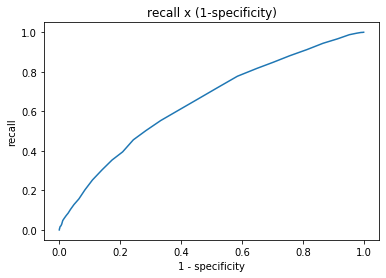

threshold ótimo: 0.353535
SKLearn Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     13216
           1       0.11      1.00      0.20      1685

    accuracy                           0.11     14901
   macro avg       0.56      0.50      0.10     14901
weighted avg       0.90      0.11      0.02     14901

Matriz de Confusão
[[   13 13203]
 [    0  1685]]


In [16]:
#threshold ótimo para os dados obtidos do modelo e analise
thresh_opt = get_thresh_opt(y_valid,y_valid_preds)
get_analysis(y_valid,y_valid_preds, thresh_opt)

### K Nearest Neighbors (KNN)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.650
accuracy:0.603
recall:0.491
precision:0.633
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.621
accuracy:0.670
recall:0.469
precision:0.165
specificity:0.655
prevalence:0.113
 


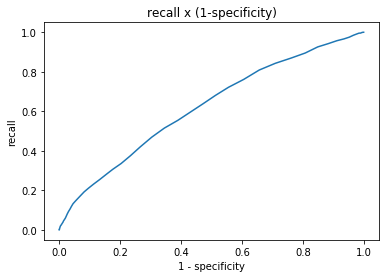

threshold ótimo: 0.262626
SKLearn Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     13216
           1       0.11      1.00      0.20      1685

    accuracy                           0.11     14901
   macro avg       0.56      0.50      0.10     14901
weighted avg       0.90      0.11      0.03     14901

Matriz de Confusão
[[   23 13193]
 [    0  1685]]


In [18]:
#threshold ótimo para os dados obtidos do modelo e analise
thresh_opt = get_thresh_opt(y_valid,y_valid_preds)
get_analysis(y_valid,y_valid_preds, thresh_opt)

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

c:\users\bunos\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression
Training:
AUC:0.678
accuracy:0.628
recall:0.558
precision:0.649
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.662
recall:0.558
precision:0.180
specificity:0.675
prevalence:0.113
 


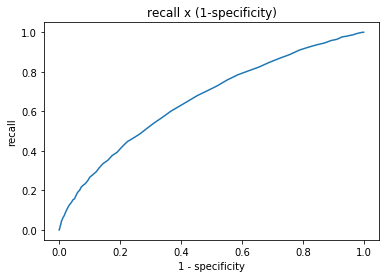

threshold ótimo: 0.151515
SKLearn Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     13216
           1       0.11      1.00      0.20      1685

    accuracy                           0.11     14901
   macro avg       0.56      0.50      0.10     14901
weighted avg       0.90      0.11      0.03     14901

Matriz de Confusão
[[   26 13190]
 [    0  1685]]


In [20]:
#threshold ótimo para os dados obtidos do modelo e analise
thresh_opt = get_thresh_opt(y_valid,y_valid_preds)
get_analysis(y_valid,y_valid_preds, thresh_opt)

### Stochastic Gradient Descent

In [21]:
from sklearn.linear_model import SGDClassifier
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.676
accuracy:0.624
recall:0.550
precision:0.645
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.664
recall:0.553
precision:0.180
specificity:0.678
prevalence:0.113
 


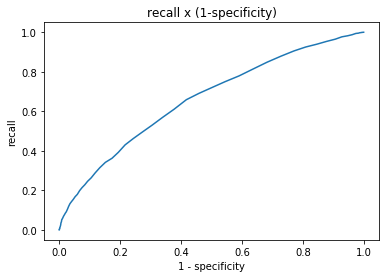

threshold ótimo: 0.232323
SKLearn Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     13216
           1       0.11      1.00      0.20      1685

    accuracy                           0.11     14901
   macro avg       0.56      0.50      0.10     14901
weighted avg       0.90      0.11      0.03     14901

Matriz de Confusão
[[   23 13193]
 [    0  1685]]


In [22]:
#threshold ótimo para os dados obtidos do modelo e analise
thresh_opt = get_thresh_opt(y_valid,y_valid_preds)
get_analysis(y_valid,y_valid_preds, thresh_opt)

### Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.508
accuracy:0.506
recall:0.989
precision:0.503
specificity:0.022
prevalence:0.500
 
Validation:
AUC:0.505
accuracy:0.129
recall:0.988
precision:0.114
specificity:0.020
prevalence:0.113
 


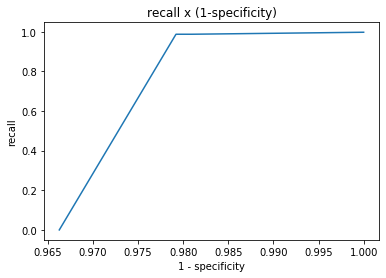

threshold ótimo: 0.000000
SKLearn Classification Report
              precision    recall  f1-score   support

           0       0.93      0.00      0.01     13216
           1       0.11      1.00      0.20      1685

    accuracy                           0.12     14901
   macro avg       0.52      0.50      0.11     14901
weighted avg       0.84      0.12      0.03     14901

Matriz de Confusão
[[   52 13164]
 [    4  1681]]


In [24]:
#threshold ótimo para os dados obtidos do modelo e analise
thresh_opt = get_thresh_opt(y_valid,y_valid_preds)
get_analysis(y_valid,y_valid_preds, thresh_opt)

### Gradient Boosting Classifier

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.772
accuracy:0.695
recall:0.668
precision:0.706
specificity:0.722
prevalence:0.500
 
Validation:
AUC:0.638
accuracy:0.620
recall:0.574
precision:0.164
specificity:0.626
prevalence:0.113
 


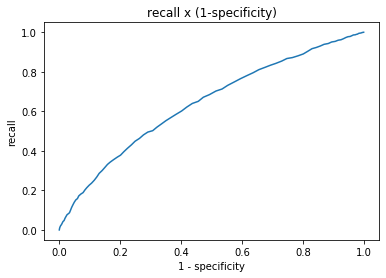

threshold ótimo: 0.010101
SKLearn Classification Report
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     13216
           1       0.11      1.00      0.20      1685

    accuracy                           0.11     14901
   macro avg       0.56      0.50      0.10     14901
weighted avg       0.90      0.11      0.03     14901

Matriz de Confusão
[[   17 13199]
 [    0  1685]]


In [26]:
#threshold ótimo para os dados obtidos do modelo e analise
thresh_opt = get_thresh_opt(y_valid,y_valid_preds)
get_analysis(y_valid,y_valid_preds, thresh_opt)